In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import xgboost as xgb


In [2]:
# Загрузка данных
train_df = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')

print(f"Размер датасета: {train_df.shape}")
print(f"\nПервые строки:")
train_df.head()

Размер датасета: (517754, 14)

Первые строки:


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


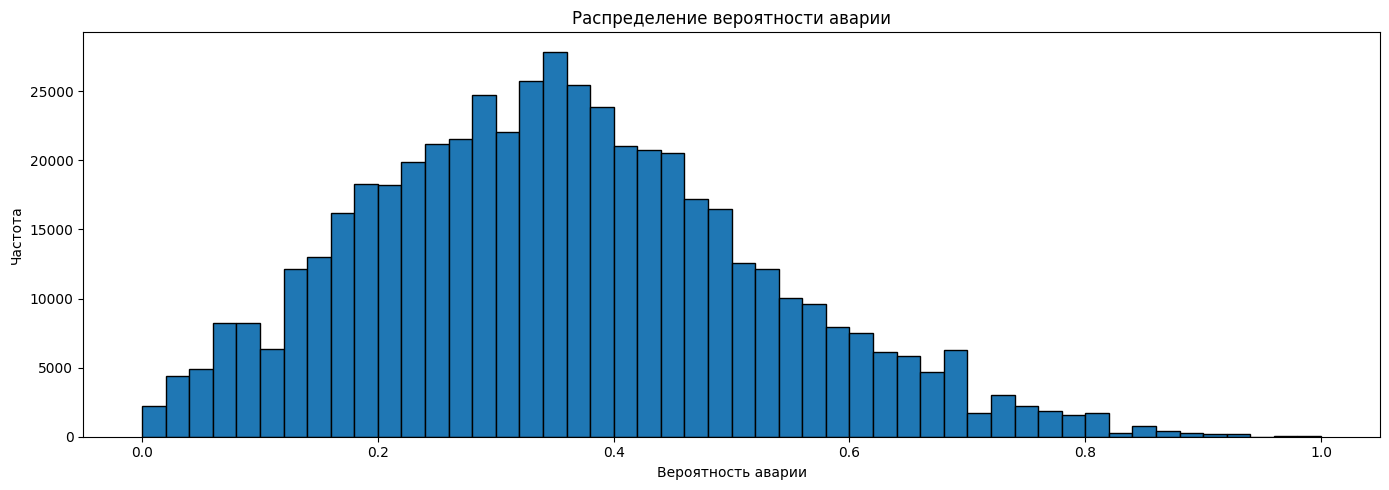

Минимум: 0.0
Максимум: 1.0
Среднее: 0.3524


In [3]:
# Анализ целевой переменной
fig, axes = plt.subplots(1, 1, figsize=(14, 5))

axes.hist(train_df['accident_risk'], bins=50, edgecolor='black')
axes.set_title('Распределение вероятности аварии')
axes.set_xlabel('Вероятность аварии')
axes.set_ylabel('Частота')

plt.tight_layout()
plt.show()

print(f"Минимум: {train_df['accident_risk'].min()}")
print(f"Максимум: {train_df['accident_risk'].max()}")
print(f"Среднее: {train_df['accident_risk'].mean():.4f}")

In [4]:
# Разделение на признаки и целевую переменную
X = train_df.drop(['id', 'accident_risk'], axis=1)
y = train_df['accident_risk']

print("Типы признаков:")
print(X.dtypes)
print("\nКатегориальные признаки:")
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
print(categorical_features)
print("\nЧисловые признаки:")
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)

Типы признаков:
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
dtype: object

Категориальные признаки:
['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']

Числовые признаки:
['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']


In [5]:
# Разделение на train/val и подготовка для двух моделей
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Подготовка для CatBoost: приведение категориальных к str
X_train_cb = X_train.copy()
X_val_cb = X_val.copy()
for col in categorical_features:
    X_train_cb[col] = X_train_cb[col].astype(str)
    X_val_cb[col] = X_val_cb[col].astype(str)

# Подготовка для XGBoost: Label Encoding
X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train_xgb[col] = le.fit_transform(X_train_xgb[col].astype(str))
    X_val_xgb[col] = le.transform(X_val_xgb[col].astype(str))
    label_encoders[col] = le

print("Train/Val размеры:", X_train.shape, X_val.shape)


Train/Val размеры: (414203, 12) (103551, 12)


In [6]:
# Обучение CatBoost
cat_model = CatBoostRegressor(
    iterations=2000,
    depth=7,
    learning_rate=0.1,
    l2_leaf_reg=3,
    subsample=0.9,
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100,
    cat_features=categorical_features,
    grow_policy='Depthwise',
    bagging_temperature=0.5
)

print("[CatBoost] Обучение...")
cat_model.fit(
    X_train_cb, y_train,
    eval_set=(X_val_cb, y_val)
)

cat_val_pred = cat_model.predict(X_val_cb)
print("[CatBoost] Готово.")


[CatBoost] Обучение...
0:	learn: 0.1521087	test: 0.1518580	best: 0.1518580 (0)	total: 214ms	remaining: 7m 6s
100:	learn: 0.0560511	test: 0.0564038	best: 0.0564038 (100)	total: 10.7s	remaining: 3m 20s
200:	learn: 0.0558652	test: 0.0563113	best: 0.0563113 (200)	total: 18.8s	remaining: 2m 47s
300:	learn: 0.0557459	test: 0.0562758	best: 0.0562758 (299)	total: 26.6s	remaining: 2m 29s
400:	learn: 0.0556367	test: 0.0562559	best: 0.0562559 (400)	total: 34.3s	remaining: 2m 16s
500:	learn: 0.0555058	test: 0.0562483	best: 0.0562444 (437)	total: 42.4s	remaining: 2m 6s
600:	learn: 0.0554230	test: 0.0562434	best: 0.0562418 (552)	total: 50.2s	remaining: 1m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05624179261
bestIteration = 552

Shrink model to first 553 iterations.
[CatBoost] Готово.


In [7]:
# Обучение XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=1200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.01,
    reg_lambda=0.1,
    gamma=0.01,
    min_child_weight=1,
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

print("[XGBoost] Обучение...")
xgb_model.fit(
    X_train_xgb, y_train,
    eval_set=[(X_train_xgb, y_train), (X_val_xgb, y_val)],
    verbose=100
)

xgb_val_pred = xgb_model.predict(X_val_xgb)
print("[XGBoost] Готово.")


[XGBoost] Обучение...
[0]	validation_0-rmse:0.16119	validation_1-rmse:0.16092
[100]	validation_0-rmse:0.05561	validation_1-rmse:0.05628
[200]	validation_0-rmse:0.05544	validation_1-rmse:0.05619
[300]	validation_0-rmse:0.05544	validation_1-rmse:0.05619
[400]	validation_0-rmse:0.05544	validation_1-rmse:0.05618
[500]	validation_0-rmse:0.05544	validation_1-rmse:0.05618
[562]	validation_0-rmse:0.05544	validation_1-rmse:0.05618
[XGBoost] Готово.


In [8]:
# Метрики отдельных моделей и простого ансамбля
print("МЕТРИКИ НА VALIDATION")

# CatBoost
cat_rmse = np.sqrt(mean_squared_error(y_val, cat_val_pred))
cat_mae = mean_absolute_error(y_val, cat_val_pred)
cat_r2 = r2_score(y_val, cat_val_pred)
print(f"CatBoost -> RMSE: {cat_rmse:.6f} | MAE: {cat_mae:.6f} | R2: {cat_r2:.6f}")

# XGBoost
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_pred))
xgb_mae = mean_absolute_error(y_val, xgb_val_pred)
xgb_r2 = r2_score(y_val, xgb_val_pred)
print(f"XGBoost  -> RMSE: {xgb_rmse:.6f} | MAE: {xgb_mae:.6f} | R2: {xgb_r2:.6f}")

# Ансамбль (простое усреднение)
ens_val_pred = (cat_val_pred + xgb_val_pred) / 2
ens_rmse = np.sqrt(mean_squared_error(y_val, ens_val_pred))
ens_mae = mean_absolute_error(y_val, ens_val_pred)
ens_r2 = r2_score(y_val, ens_val_pred)
print(f"Ensemble -> RMSE: {ens_rmse:.6f} | MAE: {ens_mae:.6f} | R2: {ens_r2:.6f}")

if ens_rmse < min(cat_rmse, xgb_rmse):
    print("\nАнсамбль улучшает качество относительно обеих моделей.")
else:
    print("\nАнсамбль не улучшил RMSE относительно лучшей одиночной модели.")


МЕТРИКИ НА VALIDATION
CatBoost -> RMSE: 0.056242 | MAE: 0.043653 | R2: 0.885444
XGBoost  -> RMSE: 0.056184 | MAE: 0.043605 | R2: 0.885678
Ensemble -> RMSE: 0.056170 | MAE: 0.043596 | R2: 0.885736

Ансамбль улучшает качество относительно обеих моделей.


In [9]:
# Submission: ансамбль CatBoost + XGBoost
try:
    test_df = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
    print(f"Тестовый набор загружен: {test_df.shape}")

    # Сохраняем ID
    test_ids = test_df['id']

    # Подготовка тестовых данных
    X_test_cb = test_df.drop(['id'], axis=1).copy()
    X_test_xgb = X_test_cb.copy()

    # CatBoost: приведение категориальных к str
    for col in categorical_features:
        if col in X_test_cb.columns:
            X_test_cb[col] = X_test_cb[col].astype(str)

    # XGBoost: Label Encoding теми же энкодерами
    for col in categorical_features:
        if col in X_test_xgb.columns:
            X_test_xgb[col] = label_encoders[col].transform(X_test_xgb[col].astype(str))

    # Предсказания
    cat_test_pred = cat_model.predict(X_test_cb)
    xgb_test_pred = xgb_model.predict(X_test_xgb)

    # Ансамбль: простое усреднение
    ensemble_test_pred = (cat_test_pred + xgb_test_pred) / 2

    submission = pd.DataFrame({
        'id': test_ids,
        'accident_risk': ensemble_test_pred
    })

    submission.to_csv('submission.csv', index=False)
    print("Ансамбль CatBoost+XGBoost сохранён в submission.csv")

    print("\nПервые строки submission:")
    print(submission.head(10))
    print("\nСтатистика предсказаний:")
    print(submission['accident_risk'].describe())

except FileNotFoundError:
    print("Файл test.csv не найден. Пропускаем создание submission.")


Тестовый набор загружен: (172585, 13)
Ансамбль CatBoost+XGBoost сохранён в submission.csv

Первые строки submission:
       id  accident_risk
0  517754       0.293497
1  517755       0.124523
2  517756       0.184195
3  517757       0.314462
4  517758       0.407323
5  517759       0.462682
6  517760       0.262877
7  517761       0.200325
8  517762       0.368035
9  517763       0.326024

Статистика предсказаний:
count    172585.000000
mean          0.351720
std           0.156737
min           0.012566
25%           0.241343
50%           0.336762
75%           0.453708
max           0.874969
Name: accident_risk, dtype: float64
